## 猫狗识别

- 数据预处理：图像数据处理，准备训练和验证数据集
- 卷积网络模型：构建网络架构
- 过拟合问题：观察训练和验证效果，针对过拟合问题提出解决方法
- 数据增强：图像数据增强方法与效果
- 迁移学习：深度学习必备训练策略（使用类似的训练模型的参数）

<img src="./img/1.png" alt="FAO" width="990">

### 导入工具包

In [14]:
import os
import warnings
warnings.filterwarnings("ignore")
import time
import datetime
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 指定好数据路径（训练和验证）

In [15]:
# 数据所在文件夹
base_dir = './data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 训练集
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 验证集
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### 构建卷积神经网络模型
- 几层都可以，大家可以随意玩
- 经典数据集，都会使用224x224x3的图片
- 如果用CPU训练，可以把输入设置的更小一些，输入大小对训练速度有较大影响，可以设置为64x64x3，速度会快10倍左右
- 或者，放到Colab中，进行运算

### Conv2D
- filters：个数
- kernel_size：filter的大小，3x3
- strides：步长
- padding：边界填充

In [16]:
model = tf.keras.models.Sequential([
    # 如果训练慢，可以把数据设置的更小一些
    # 32：filters；
    # (3,3)：kernel_size
    # MaxPooling2D(2, 2)：W、H为原来的1/2
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # 为全连接层准备，Flatten拉长操作
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    # 二分类sigmoid就够了
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

#### Param 计算
3x3x3x32+32
kernel_size的乘积，乘以图像层数，乘以filters数量，加上偏置项的数量

### 配置训练器

In [18]:
# 损失函数，优化器，评估标准
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

### 数据预处理

- 读进来的数据会被自动转换成tensor(float32)格式，分别准备训练和验证
- 图像数据归一化（0-1）区间

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # 文件夹路径
        target_size=(64, 64),  # 指定resize成的大小
        batch_size=20,
        # 如果one-hot就是categorical，二分类用binary就可以
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 训练网络模型
- 直接fit也可以，但是通常内存没有那么大，不能把所有数据全部放入内存，fit_generator相当于一个生成器，动态产生所需的batch数据
- steps_per_epoch相当给定一个停止条件，因为生成器会不断产生batch数据，说白了就是它不知道一个epoch里需要执行多少个step

In [21]:
start_time = time.time()
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)
print(datetime.timedelta(seconds = time.time() - start_time))

Epoch 1/20
100/100 - 12s - loss: 0.6939 - acc: 0.5095 - val_loss: 0.6875 - val_acc: 0.5170
Epoch 2/20
100/100 - 13s - loss: 0.6694 - acc: 0.5870 - val_loss: 0.6640 - val_acc: 0.5930
Epoch 3/20
100/100 - 12s - loss: 0.6373 - acc: 0.6475 - val_loss: 0.6312 - val_acc: 0.6400
Epoch 4/20
100/100 - 12s - loss: 0.5908 - acc: 0.6900 - val_loss: 0.5956 - val_acc: 0.6780
Epoch 5/20
100/100 - 12s - loss: 0.5576 - acc: 0.7135 - val_loss: 0.5958 - val_acc: 0.6820
Epoch 6/20
100/100 - 12s - loss: 0.5152 - acc: 0.7585 - val_loss: 0.5826 - val_acc: 0.6910
Epoch 7/20
100/100 - 12s - loss: 0.4861 - acc: 0.7780 - val_loss: 0.5607 - val_acc: 0.7210
Epoch 8/20
100/100 - 13s - loss: 0.4659 - acc: 0.7895 - val_loss: 0.5842 - val_acc: 0.6910
Epoch 9/20
100/100 - 14s - loss: 0.4295 - acc: 0.8150 - val_loss: 0.5536 - val_acc: 0.7290
Epoch 10/20
100/100 - 14s - loss: 0.4189 - acc: 0.8130 - val_loss: 0.5430 - val_acc: 0.7430
Epoch 11/20
100/100 - 14s - loss: 0.3806 - acc: 0.8370 - val_loss: 0.5931 - val_acc: 0.70

### 效果展示

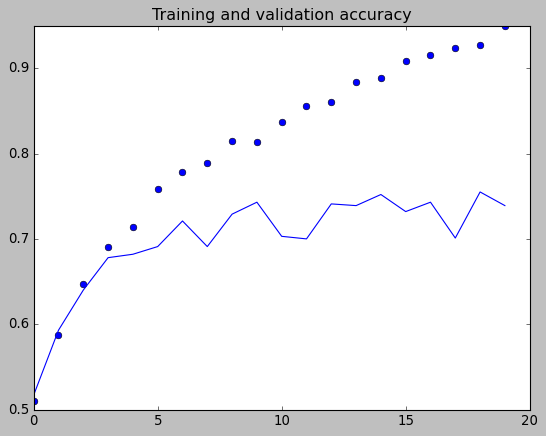

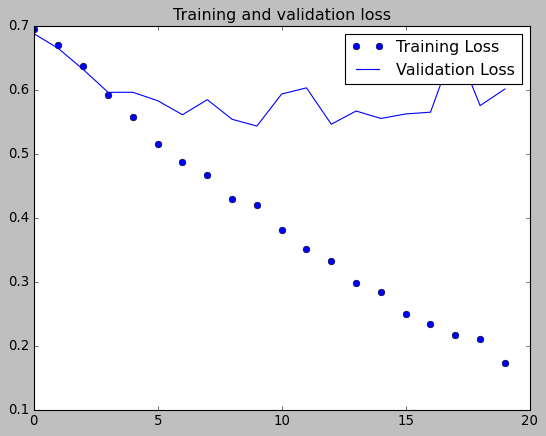

0:00:00.148417


In [23]:
import matplotlib.pyplot as plt
plt.style.use('classic')
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

看起来完全过拟合了，如何解决呢？

先从数据下手